# Measuring Interest Rate Risk with Duration

## Preparing the Notebook

### Importing libraries, modules, and functions


As in earlier chapters of the volume, modules that are included in the standard Python library are imported. When necessary, other modules or libraries are installed before they are imported.$^{2}$.  Because pandas_data_reader is not part of the Pandas library, it is imported and when necessary installed.

```
import sys
import requests
from types import ModuleType
from datetime import datetime, date

try:
    import numpy as np
except:
    !pip install numpy
    import numpy as np

try:
    import pandas as pd
except:
    !pip install pandas
    import pandas as pd
try:
    import pandas_datareader as pdr
except:
    !pip install pandas-datareader
    import pandas_datareader as pdr    
```
---


$^{2}$For more information on <font color='green'>try</font> and <font color='green'>except</font> statements, see “<a href='https://patrickjhess.github.io/Introduction-To-Python-For-Financial-Python/Control_Statements.html#the-try-and-except'>Control Statements</a>.”

In [1]:
# Import OS to interact with local computer operating system
import os
import sys
import requests
from types import ModuleType
# Import the datetime and date classes from the datetime module for working with dates.
from datetime import datetime, date
# Last calendar day of the month and day of the week for first day
import calendar
# Import the NumPy library for numerical operations, commonly aliased as np.
try:
    import numpy as np
except:
    !pip install numpy
    import numpy as np

# Import the pandas library for data manipulation and analysis, aliased as pd.
try:
    import pandas as pd
except:
    !pip install pandas
    import pandas as pd

# Import (when necessary install) pandas_data_reader as pdr.
try:
    import pandas_datareader as pdr
except:
    !pip install pandas-datareader
    import pandas_datareader as pdr

# Import relativedelta (when necessary install) as relativedelta
try:
    from dateutil.relativedelta import relativedelta
except:
    !pip -q install python-dateutil
    from dateutil.relativedelta import relativedelta

## Adding a Custom Module and Importing Functions
The notebook utilizes the custom module, **module_basic_concepts_fixed_income**, sourced from Dropbox and named **basic_concepts_fixed_income**. This module provides five core functions to streamline the focus on financial concepts:


* **bond_pay_data** ([Chapter Three](https://patrickjhess.github.io/Vol-3-Chap-2-Chap-3/Bond_Pay_Dates.html#bond-payment-dates)): Returns the payment dates and amounts.  
  * [View Details](https://patrickjhess.github.io/Imported-Functions/bond_pay_data.html#bond-pay-data-helper-function)

  **calc_ytm** ([Chapter Six](https://patrickjhess.github.io/Vol-3-Chap-6/Calculating_Yields_To_Maturity.html#adding-yield-to-maturity-to-bond-data): Returns the yield to maturity for bond with a known price, maturity, coupon, and settlement date..  
  * [View Details](https://patrickjhess.github.io/Imported-Functions/calc_ytm.html)

* **bond_pv** ([Chapter Six](https://patrickjhess.github.io/Vol-3-Chap-6/Calculating_Yields_To_Maturity.html#demonstrating-bond-pv)): Returns the present value of a bond.  
  * [View Details](https://patrickjhess.github.io/Imported-Functions/bond_pv.html)

* **accrued_interest** ([Chapter Two](https://patrickjhess.github.io/Vol-3-Chap-2-Chap-3/Chapter_Two_Accrued_Interest.html#calculating-accrued-interest-for-five-bonds-dataframe)): Returns the payment dates and amounts.  
  * [View Details](https://patrickjhess.github.io/Imported-Functions/accrued_interest.html)

* **one_y_axis** ([Chapter One](https://patrickjhess.github.io/Vol-3-Chap-1/Calculating_And_Graphing_The_Term_Structure_Of_Interest_Rates.html#graphing-the-spot-and-forward-rates-for-september-30-2025)): Plots the yields to maturity of the 304 bonds.  
  * [View Details](https://patrickjhess.github.io/Imported-Functions/one_y_axis.html)


The module also contains various supporting helper functions, and it automatically manages the import and, if required, installation of necessary libraries and modules. This structure allows the user to concentrate fully on financial principles rather than complex Python implementation details.


```
from basic_concepts_fixed_income import(bond_pay_data,
                                        calc_ytm,
                                        bond_pv,
                                        accrued_interest,
                                        one_y_axis)
```



In [2]:
# Define the URL of the Python module to be downloaded from Dropbox.
# The 'dl=1' parameter in the URL forces a direct download of the file content.
url= 'https://www.dropbox.com/scl/fi/4y5hjxlfphh1ngvbgo77q/\
module_-basic_concepts_fixed_income.py?rlkey=6oxi7mgka42veaat79hcv8boz&st=87sztshr&dl=1'
module_name='basic_concepts_fixed_income'
# Send an HTTP GET request to the URL and store the server's response.
try:
  response=requests.get(url)
  # Raise an exception for bad status codes (like 404 Not Found)
  response.raise_for_status()
  module= ModuleType(module_name)
  #Code contained in response.text executed
  exec(response.text, module.__dict__)
  # Module added to sys
  sys.modules[module_name]=module
except requests.exceptions.RequestException as e:
    print(f"❌ Error: Could not fetch module from URL. {e}")
except Exception as e:
    print(f"❌ Error: Failed to execute or import the module. {e}")
# Open the local file in "write binary" ('wb') mode and save the downloaded content.
# Using a 'with' statement ensures the file is properly closed after writing.

# Now that 'basic_concepts_fixed_income' exists in the notebook, import the specific functions
from basic_concepts_fixed_income import(bond_pay_data,
                                        calc_ytm,
                                        bond_pv,
                                        accrued_interest,
                                        one_y_axis)

## Calculating Duration

Duration equals minus the first derivative divided by the value of the bond.

In the code below <font color='green'>bond_paydata</font> and <font color='green'>bond_pv</font> functions are called.  The <font color='green'>calc_ytm</font> function is only called when <font color='green'>rates</font> is assigned None or a value less than or equal to zero. An iterable (list) is assigned, but a scalar may be assigned as well.

Because <font color='green'>price</font> is 100, the bond has a par yield equal to the value assigned to <font color='green'>coupon</font>.  Because the calculation of yield to maturity assumes continuous compounding, the yield is less than the value assigned to <font color='green'>coupon</font>.


In [3]:
# set settlement date
settlement=date(2025,1,21)

# set bond attributes
maturity=date(2040,1,21)
coupon=5
price=100

# check setlement
if settlement is None:
  settlement=date.today()
# calculation of rates
# if bond sells for 100 ytm calculated from par yield
if price == 100:
  rates=2*np.log(1+coupon/200)

# if rates None or zero, calculate as yield to maturity
if not rates:
      if price is None:
          raise ValueError("Must provide either 'rates' (yield) or 'price'.")
      # FIX: Use the actual 'price' variable, not hardcoded 100
      rates = calc_ytm(price, maturity, coupon, settlement=settlement)

# Handle iterable rates (e.g. if user passed a list of rates)
elif hasattr(rates, '__iter__'):
      rates = rates[0]
# Sanity check: If rate calculation resulted in <= 0, try recalculating
if isinstance(rates, (int, float)) and rates <= 0:
        # Fallback to Par yield if calculation failed or input was bad
        rates = calc_ytm(100, maturity, coupon, settlement=settlement)

# data for bond_pv function
pay_data=bond_pay_data(maturity,coupon,settlement=settlement)
data_dict={'pay_data':pay_data,'settlement':settlement}

value,derivative_first,_=bond_pv(rates=rates,data_dict=data_dict)


# calculate maturity in years and duration
maturity_years=(maturity-settlement).days/365.25
duration=-derivative_first/value

display(f'Maturity In Years {maturity_years:.2F},\
 Duration in Years {duration: .2F}, Yield To Maturity {rates: .3F}')

'Maturity In Years 15.00, Duration in Years  10.73, Yield To Maturity  0.049'

## The Function <font color='green'>calc_duration</font>
The function calculates the duration of a bond.  Arguments must be passed for the bond's price, maturity, and coupon.  Settlement defaults to the current date and the frequency of payment to semi-annual.

 Arguments must be:

*   maturity and settlement must be date or datetime objects
*   price and coupon must be floating points or integers
*   frequency must be an integer 1 ,2, 4, or 12.



In [4]:
def calc_duration(maturity, coupon,price=None,
                  rates=None,settlement=None, freq=2):
  '''
  Calculates modified duration for a bond.
  Helper functions:
   calc_ytm, bond_pay_data, bond_pv
  Arguments are:
    price: current price of the bond (required for calc_ytm)
    maturity:
      bond's maturity date-datetime or date object (required for calc_ytm, bond_pay_data)
    coupon: bond's annual coupon of par (reqired for calc_ytm and bond_pay_data)
    settlement: bond's settlement date (optional default to current date)
    freq: payment frequency  (optional defaults to 2 for semi-annual (1,2,4 or 12))
  '''
  from datetime import date

  # check settlement
  if settlement is None:
    settlement=date.today()
  # calculation of rates
  # if bond sells for 100 ytm calculated from par yield
  if price == 100:
    rates=2*np.log(1+coupon/200)

  # if rates None or zero, calculate as yield to maturity
  if not rates:
        if price is None:
            raise ValueError("Must provide either 'rates' (yield) or 'price'.")
        # FIX: Use the actual 'price' variable, not hardcoded 100
        rates = calc_ytm(price, maturity, coupon, settlement=settlement)

  # Handle iterable rates (e.g. if user passed a list of rates)
  elif hasattr(rates, '__iter__'):
        rates = rates[0]
  # Sanity check: If rate calculation resulted in <= 0, try recalculating
  if isinstance(rates, (int, float)) and rates <= 0:
         # Fallback to Par yield if calculation failed or input was bad
         rates = calc_ytm(100, maturity, coupon, settlement=settlement)

  # data for bond_pv function
  pay_data=bond_pay_data(maturity,coupon,settlement=settlement)
  data_dict={'pay_data':pay_data,'settlement':settlement}

  # calculate present value and first derivative
  value,derivative_first,_=bond_pv(rates=rates,data_dict=data_dict)

  # calculate duration and return value
  duration=-derivative_first/value
  return duration

## <font color='green'>Application: Calculate Duration with Different Maturities, Coupons, and Rates.</font>


<div style="
    border-left: 12px solid green;
    line-height: 1.5;
    padding: 15px">
<br>



|Maturity|Coupon|Rate|
|-------|-------|---------|
|&nbsp;&nbsp;&nbsp;January 21$^{st}$ 2030|&nbsp;&nbsp;&nbsp;5|&emsp;4%|
|&nbsp;&nbsp;&nbsp;January 21$^{st}$ 2030|&nbsp;&nbsp;&nbsp;5|&emsp;7%|
|&nbsp;&nbsp;&nbsp;January 21$^{st}$ 2030|&nbsp;&nbsp;&nbsp;2|&emsp;4%|
|&nbsp;&nbsp;&nbsp;January 21$^{st}$ 2040|&nbsp;&nbsp;&nbsp;5|&emsp;7%|
|&nbsp;&nbsp;&nbsp;January 21$^{st}$ 2040|&nbsp;&nbsp;&nbsp;0|&emsp;4%|





 see [Chapter Seven Hints: Calculate duration with different maturities, coupons, and rates.](https://patrickjhess.github.io/Hints-Results/Chapter_Seven_Hints.html#chapter-seven-hints), and check the [expected results here](https://patrickjhess.github.io/Hints-Results/Chapter_Seven_Hints.html#chapter-seven-results).

</div>

## Demonstrating <font color='green'>calc_duration</font> with 304 Fidelity Bonds

Duration is calculated for the 304 bonds that are downloaded from DropBox

## Downloading the Data for the 304 Bonds

In [5]:
#The full file path.
url='https://www.dropbox.com/scl/fi/lgnaj41bt8o9sv5a63rr1/\
bond_data_jan21_2025.xlsx?rlkey=twjzkcqo0g2ahvot78518ti4x&st=ihc5feog&dl=1'
print(f"Attempting to load data from: {url}")

#Load the data from Excel, using the first column as the index.
try:
    bond_data = pd.read_excel(url, index_col=0,sheet_name='Fidelity Data')

    # Display the first and last 5 rows of the loaded DataFrame to verify it worked..
    display(bond_data)

except FileNotFoundError:
    print("\nERROR: File not found.")
    print("Please check that the 'folder' and 'file' variables are spelled correctly'\
' and that the file exists in that location.")

Attempting to load data from: https://www.dropbox.com/scl/fi/lgnaj41bt8o9sv5a63rr1/bond_data_jan21_2025.xlsx?rlkey=twjzkcqo0g2ahvot78518ti4x&st=ihc5feog&dl=1


,Description,Coupon,Price Bid,Price Ask,Bid Size,Ask Size
Maturity Date,,,,,,
2025-01-28,UNITED STATES TREAS BILLS ZERO CPN 0.000...,0.000,99.929,99.930,100000.0,100000.0
2025-01-30,UNITED STATES TREAS BILLS ZERO CPN 0.000...,0.000,99.906,99.907,40000.0,40000.0
2025-01-31,UNITED STATES TREAS SER U-2025 1.3750...,1.375,99.921,99.934,60000.0,60000.0
2025-01-31,UNITED STATES TREAS SER AW-2025 4.1250...,4.125,99.988,99.997,60000.0,60000.0
2025-01-31,UNITED STATES TREAS SER G-2025 2.5000...,2.500,99.953,99.965,60000.0,60000.0
...,...,...,...,...,...,...
2029-11-30,UNITED STATES TREAS SER AG-2029 4.1250...,4.125,98.910,98.914,100000.0,100000.0
2029-11-30,UNITED STATES TREAS SER S-2029 3.8750...,3.875,97.763,97.782,40000.0,40000.0
2029-12-31,UNITED STATES TREAS SER T-2029 3.8750...,3.875,97.734,97.738,65000.0,65000.0


## The Duration Calculations

*   The <font color='green'>calc_duration</font> function calculates the duration but requires the transaction prices for <font color='green'>calc_ytm</font>.
*   The <font color='green'>accrued_interest</font> function is needed to calculate transaction prices.
*   The Pandas <font color='green'>apply</font> method is used to calculate the *Accrued* and *Duration* columns of the <font color='green'>bond_data</font> DataFrame.



In [6]:
settlement=date(2025,1,21)
# apply the accrued_interest function to the DataFrame
bond_data['Accrued'] = bond_data.apply(
    lambda x: accrued_interest(
        maturity=x.name, # Assuming index is maturity
        coupon=x['Coupon'],
        settlement=settlement,
        freq=2,
        day_type='Actual/Actual'
    ), axis=1
)
bond_data['Duration'] = bond_data.apply(
    lambda x: calc_duration(
        price=(x['Price Bid']+x['Price Ask'])/2+x['Accrued'],
        maturity=x.name, # Assuming index is maturity
        coupon=x['Coupon'],
        settlement=settlement,
    ), axis=1
)
display(bond_data)

,Description,Coupon,Price Bid,Price Ask,Bid Size,Ask Size,Accrued,Duration
Maturity Date,,,,,,,,
2025-01-28,UNITED STATES TREAS BILLS ZERO CPN 0.000...,0.000,99.929,99.930,100000.0,100000.0,0.000000,0.019165
2025-01-30,UNITED STATES TREAS BILLS ZERO CPN 0.000...,0.000,99.906,99.907,40000.0,40000.0,0.000000,0.024641
2025-01-31,UNITED STATES TREAS SER U-2025 1.3750...,1.375,99.921,99.934,60000.0,60000.0,0.650136,0.027379
2025-01-31,UNITED STATES TREAS SER AW-2025 4.1250...,4.125,99.988,99.997,60000.0,60000.0,1.950408,0.027379
2025-01-31,UNITED STATES TREAS SER G-2025 2.5000...,2.500,99.953,99.965,60000.0,60000.0,1.182065,0.027379
...,...,...,...,...,...,...,...,...
2029-11-30,UNITED STATES TREAS SER AG-2029 4.1250...,4.125,98.910,98.914,100000.0,100000.0,0.589286,4.423116
2029-11-30,UNITED STATES TREAS SER S-2029 3.8750...,3.875,97.763,97.782,40000.0,40000.0,0.553571,4.444625
2029-12-31,UNITED STATES TREAS SER T-2029 3.8750...,3.875,97.734,97.738,65000.0,65000.0,0.234203,4.529284


## Results of the Calculations Mimic our Discussion of Duration

*   Duration for the first five bonds equals the number of days between their maturity and the settlement date of January 21$^{st}$ 2025 divided by 365.25.
*   The last bond has a maturity of five years and 10 days and its duration is slightly more than four and half years.
*   The difference (4.5648 versus 4.4866) in the durations of the bonds maturity on December 31$^{st}$ is inversely related to their respective coupons 4.375 versus 3.500).





## The Relation between Coupon Rates and Duration
The relation between coupon rates and durations is demonstrated with historical par yields.  The six-month, ten-year, and thirty-year par yields are downloaded from the FRED database. FRED refers to par yields as yields on constant maturity U.S Treasury securities.


## Use Pandas Reader to Access Par Yield Data from FRED between January 1$^{st}$ 1990 and December 31$^{st}$ 2025

*  **Six-month Par Yields**: series id <font color='green'>dgs6mo</font>
*  **Ten-year U.S. Treasury Par Yields**: series id <font color='green'>dgs10</font>
*  **Thirty-year U.S. Treasury Par Yields**: series id <font color='green'>dgs30</font>


In [7]:
# set the start and end dates
start_date = date(1990, 1, 1)
end_date = date(2025,12,31)

# series ids
series_ids = ['dgs6mo','dgs10','dgs30']
# use pandas reader to get data from Fred
par_yields_daily = pdr.get_data_fred(series_ids, start_date, end_date)

# if any values are missing drop the row
par_yields_daily .dropna(how='any',inplace=True)
display(par_yields_daily )

,dgs6mo,dgs10,dgs30
DATE,,,
1990-01-02,7.89,7.94,8.00
1990-01-03,7.94,7.99,8.04
1990-01-04,7.90,7.98,8.04
1990-01-05,7.85,7.99,8.06
1990-01-08,7.88,8.02,8.09
...,...,...,...
2025-12-24,3.59,4.15,4.79
2025-12-26,3.58,4.14,4.81
2025-12-29,3.59,4.12,4.80


## Demonstrate the Relation between Coupon Rate and Duration

* **Minimum par yields for each maturity:** <font color='green'>min_par_yields</font>
* **Maximum par yields for each maturity:** <font color='green'>max_par_yields</font>




In [8]:
# Pandas min and max methods find minimum and maximum par yields
min_par_yields=[par_yields_daily[column].min()/100 for column in par_yields_daily.columns]
max_par_yields=[par_yields_daily[column].max()/100 for column in par_yields_daily.columns]

# display minimum and maximum values
pd.DataFrame({'Minimum Par Yields':min_par_yields,
              'Maximum Par Yields':max_par_yields},
             index=['Six-Month Par Yield',
                    'Ten-Year Par Yield',
                    'Thirty-Year Par Yield'])

,Minimum Par Yields,Maximum Par Yields
Six-Month Par Yield,0.0002,0.0849
Ten-Year Par Yield,0.0052,0.0909
Thirty-Year Par Yield,0.0099,0.0918


## <font color='green'>Application: Calculate Duration with Minimum and Maximum Par Yields</font>


<div style="
    border-left: 12px solid green;
    line-height: 1.5;
    padding: 15px">

<br>

**Settlement date is December 31$^{st}$ 2025**

|Maturity|Minimum Coupon|Maximum Coupon|Rate|
|-------|-------|---------|-------|
|&nbsp;&nbsp;&nbsp;June 30$^{th}$ 2026|&nbsp;&nbsp;&nbsp;0.02|&nbsp;&nbsp;&nbsp;8.49|&emsp;4.50%|
|&nbsp;&nbsp;&nbsp;December 31$^{st}$ 2035|&nbsp;&nbsp;&nbsp;0.52|&nbsp;&nbsp;&nbsp;9.09|&emsp;4.75%||
|&nbsp;&nbsp;&nbsp;December 31$^{st}$ 2055|&nbsp;&nbsp;&nbsp;0.99|&nbsp;&nbsp;&nbsp;9.18|&emsp;5.00%|




 see [Chapter Seven Hints: Calculate Duration with Minimum and Maximum Par Yields](https://patrickjhess.github.io/Hints-Results/Chapter_Seven_Hints.html#chapter-seven-hints), and check the [expected results here](https://patrickjhess.github.io/Hints-Results/Chapter_Seven_Hints.html#chapter-seven-results).

</div>

## Relation between Par Yields and Duration of Bonds Issued at Par.

You could, of course, use all 9,005 days to illustrate the relation between coupons and duration. It's sufficient to look at the par yields on the first settlement day of each month, and that's what we do here.  Because the first day of a month is often not a settlement date, we can't simply use the <font color='green'>is_month_start</font> attribute.  Instead:



1.   the method <font color='green'>to_period</font> is used to convert the dates of the index to years and months.
2.   the  <font color='green'>duplicated</font> method returns True if a value repeats an existing value; otherwise False.
3.   the tilde (<font color='green'>~</font>) negates the value returned by <font color='green'>duplicated</font>.
4.   the DataFrame <font color='green'>par_yields_monthly</font> includes the first yield occurrence of every month.



## Get Par Yields for First Day of the Month

In [9]:
# create a period index to group dates by month
months_years = par_yields_daily.index.to_period('M')

# identify the first record for every unique month-year
is_month_start = ~months_years.duplicated()

# downsample the data to monthly frequency
# copy method creates standalone DataFrame
par_yields_monthly = par_yields_daily[is_month_start].copy()
display(par_yields_monthly)

,dgs6mo,dgs10,dgs30
DATE,,,
1990-01-02,7.89,7.94,8.00
1990-02-01,8.13,8.42,8.44
1990-03-01,8.19,8.59,8.61
1990-04-02,8.23,8.65,8.63
1990-05-01,8.49,9.08,9.04
...,...,...,...
2025-08-01,4.16,4.23,4.81
2025-09-02,3.99,4.28,4.97
2025-10-01,3.80,4.12,4.72


## Calculation of Duration with Par Yields on the First Day of the Month

The durations for the bonds are determined by their constant maturities that are set relative to a presumed maturity in ten or thirty years. These calculations illustrate the bonds' durations based on the par yields from a specific date.; however, the date itself is irrelevant for the calculations. The durations are solely dependent on the assumed bond coupons (the par yields) and their yields to maturity (the par yields adjusted for continuous vs. semi-annual compounding), not the observation date of those values.

In [10]:
# settlement date is arbitrarily set for December 31, 2025
settlement=date(2025,12,31)

# maturity dates are fixed relative to fixed settlement date
maturity_10=settlement+relativedelta(years=10)
maturity_30=settlement+relativedelta(years=30)

# pandas apply method used to calculate duration on monthly intervals
# ten year par yields
par_yields_monthly['Duration Ten'] = par_yields_monthly.apply(
    lambda x: calc_duration(
        price=100,
        maturity=maturity_10,
        coupon=x['dgs10'],
        settlement=settlement,
        rates=2*np.log(1+x['dgs10']/200)
    ), axis=1
)
# thirty year par yields
par_yields_monthly['Duration Thirty'] =par_yields_monthly.apply(
    lambda x: calc_duration(
        price=100,
        maturity=maturity_30,
        coupon=x['dgs30'],
        settlement=settlement,
        rates=2*np.log(1+x['dgs30']/200)
    ), axis=1
)
display(par_yields_monthly)

,dgs6mo,dgs10,dgs30,Duration Ten,Duration Thirty
DATE,,,,,
1990-01-02,7.89,7.94,8.00,7.083136,11.763721
1990-02-01,8.13,8.42,8.44,6.950784,11.313746
1990-03-01,8.19,8.59,8.61,6.904859,11.147811
1990-04-02,8.23,8.65,8.63,6.888766,11.128568
1990-05-01,8.49,9.08,9.04,6.775186,10.746534
...,...,...,...,...,...
2025-08-01,4.16,4.23,4.81,8.255865,16.174735
2025-09-02,3.99,4.28,4.97,8.238098,15.892981
2025-10-01,3.80,4.12,4.72,8.295160,16.336701


## Graph of Ten and Thirty Year Par Yield Duration Against Par Yields.

Analysis of the DataFrame reveals a negative correlation between par yields and duration. The subsequent code generates a graph comparing the ten and thirty-year duration estimates to the thirty-year par yields

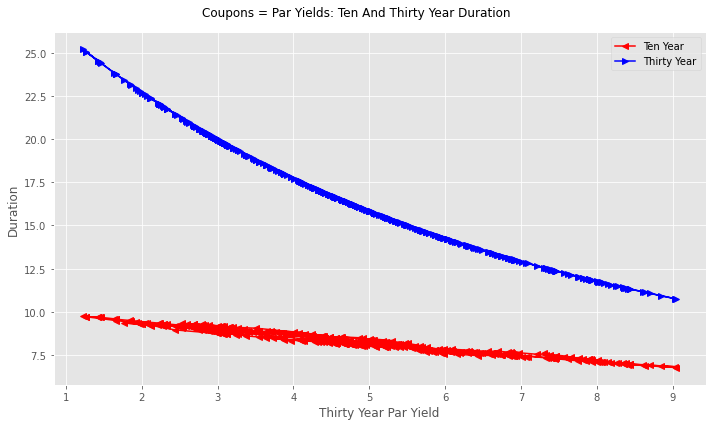

In [11]:
save_config={}
xaxis=par_yields_monthly['dgs30']
data=[par_yields_monthly['Duration Ten'],par_yields_monthly['Duration Thirty']]
try:
    title = os.path.splitext(save_config['file_name'])[0]
#'file_name key not found set a default title.
except:
    title = 'Coupons = Par Yields: Ten And Thirty Year Duration'

# Define the names for the data series that will appear in the plot's legend.
series = ['Ten Year', 'Thirty Year']

# Define the label for the y-axis.
ylabel = 'Duration'

# Define the label for the x-axis.
xlabel = 'Thirty Year Par Yield'

#'data' contains two series (ten and thirty durations).
x = len(data)

# Define markers for the plot.
markers = ['<','>']*round(x/2+x%2+0.001)

# Define the lower bound for the y-axis.
lower = min(np.nanmin(data[0]), np.nanmin(data[1])) -1

# Define the upper bound for the y-axis.
# considering NaN values (not a number) and adds a small buffer (0.5) for padding.
upper = max(np.nanmax(data[0]), np.nanmax(data[1])) + 1

# Define the y-axis limits (minimum and maximum values).
ylim = [lower, upper]

# Define the size of the plot (width, height) in inches.
size = (10, 6)
# Define colors as red and blue
colors=['r','b']
# This function generates and possibly saves a plot.
one_y_axis(xaxis, data, title, series, xlabel, ylabel, markers, size, ylim,
           save_config=save_config,colors=colors)

## Negative Relation between Duration and Coupon
Consistent with our earlier conversation, duration decreases as the yield to maturity increases. The slight curvature observed in the graphs reflects the strong relationship between coupons (par yields) and the yield to maturity (par yields adjusted for continuous versus semi-annual compounding).


## Graph of Par Yield Duration between January 1990 and December 2025

The time series analysis of par yield durations reveals a strong inverse relationship between par yields and duration. This is consistent with the steady decline in interest rates, and consequently par yields, observed between January 1990 and December 2025.

A significant shift in yields occurred beginning in early 2007, and more dramatically in late 2008 and 2009, when the Federal Reserve actively intervened in financial markets. This intervention involved a substantial expansion of its balance sheet through the purchase of mortgages and Treasury bonds. These bond purchases suppressed interest rates, resulting in higher duration estimates.

For investors, this policy presented a dual risk. While the expansion or maintenance of the Fed's balance sheet ensured bond price stability, the eventual unwinding of the balance sheet was inevitable. This unwinding materialized in 2022, when the secured overnight financing rate (SOFR) escalated sharply from 0.05% in March 2022 to 5.33% in August 2023. By the end of 2025, the rate had moderated to 3.75%. The pattern observed in the plot of par yield durations closely mirrors these events.


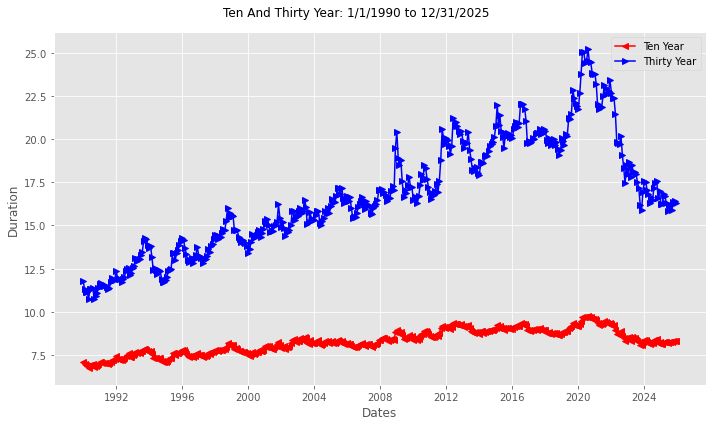

In [12]:
save_config={}
xaxis=par_yields_monthly.index
data=[par_yields_monthly['Duration Ten'],par_yields_monthly['Duration Thirty']]
try:
    title = os.path.splitext(save_config['file_name'])[0]
#'file_name key not found set a default title.
except:
    title = 'Ten And Thirty Year: 1/1/1990 to 12/31/2025'

# Define the names for the data series that will appear in the plot's legend.
series = ['Ten Year', 'Thirty Year']

# Define the label for the y-axis.
ylabel = 'Duration'

# Define the label for the x-axis.
xlabel = 'Dates'

#'data' contains two series (ten and thirty durations).
x = len(data)

# Define markers for the plot.
markers = ['<','>']*round(x/2+x%2+0.001)

# Define the lower bound for the y-axis.
lower = min(np.nanmin(data[0]), np.nanmin(data[1])) -1

# Define the upper bound for the y-axis.
# considering NaN values (not a number) and adds a small buffer (0.5) for padding.
upper = max(np.nanmax(data[0]), np.nanmax(data[1])) + 1

# Define the y-axis limits (minimum and maximum values).
ylim = [lower, upper]

# Define the size of the plot (width, height) in inches.
size = (10, 6)
# Define colors as red and blue
colors=['r','b']
# This function generates and possibly saves a plot.
one_y_axis(xaxis, data, title, series, xlabel, ylabel, markers, size, ylim,
           save_config=save_config,colors=colors)

## Duration and Coupon for Constant 5% Yield to Maturity



In [13]:
# settlement date is arbitrarily set for December 31, 2025
settlement=date(2025,12,31)

# maturity dates are fixed relative to fixed settlement date
maturity_10=settlement+relativedelta(years=10)
maturity_30=settlement+relativedelta(years=30)

# pandas apply method used to calculate duration on monthly intervals
# ten year par yields
par_yields_monthly['Duration Ten Rate 5%'] = par_yields_monthly.apply(
    lambda x: calc_duration(
        maturity=maturity_10,
        coupon=x['dgs10'],
        settlement=settlement,
        rates=0.05
    ), axis=1
)
# thirty year par yields
par_yields_monthly['Duration Thirty Rate 5%'] =par_yields_monthly.apply(
    lambda x: calc_duration(
        maturity=maturity_30,
        coupon=x['dgs30'],
        settlement=settlement,
        rates=0.05
    ), axis=1
)
display(par_yields_monthly)

,dgs6mo,dgs10,dgs30,Duration Ten,Duration Thirty,Duration Ten Rate 5%,Duration Thirty Rate 5%
DATE,,,,,,,
1990-01-02,7.89,7.94,8.00,7.083136,11.763721,7.395215,14.459489
1990-02-01,8.13,8.42,8.44,6.950784,11.313746,7.319505,14.333849
1990-03-01,8.19,8.59,8.61,6.904859,11.147811,7.293754,14.288248
1990-04-02,8.23,8.65,8.63,6.888766,11.128568,7.284792,14.282984
1990-05-01,8.49,9.08,9.04,6.775186,10.746534,7.222431,14.179501
...,...,...,...,...,...,...,...
2025-08-01,4.16,4.23,4.81,8.255865,16.174735,8.184124,15.898275
2025-09-02,3.99,4.28,4.97,8.238098,15.892981,8.170272,15.792071
2025-10-01,3.80,4.12,4.72,8.295160,16.336701,8.215008,15.960435


When deriving the yield to maturity (YTM) from par yields, the influence of coupon rates is magnified because lower coupons are matched with lower YTMs and higher coupons are matched with higher YTMs. By fixing the YTM, the focus shifts to the coupon effect. This results in a curve that relates duration and coupon rates. When the YTM is fixed, the duration of bonds with the lowest coupons are less than the par yield estimates, and those with the highest coupons are greater.


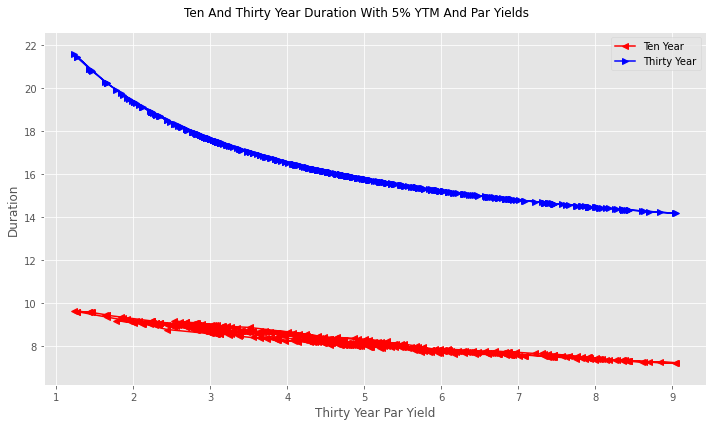

In [14]:
save_config={}
xaxis=par_yields_monthly['dgs30']
data=[par_yields_monthly['Duration Ten Rate 5%'],par_yields_monthly['Duration Thirty Rate 5%']]
try:
    title = os.path.splitext(save_config['file_name'])[0]
#'file_name key not found set a default title.
except:
    title = 'Ten And Thirty Year Duration With 5% YTM And Par Yields'

# Define the names for the data series that will appear in the plot's legend.
series = ['Ten Year', 'Thirty Year']

# Define the label for the y-axis.
ylabel = 'Duration'

# Define the label for the x-axis.
xlabel = 'Thirty Year Par Yield'

#'data' contains two series (ten and thirty durations).
x = len(data)

# Define markers for the plot.
markers = ['<','>']*round(x/2+x%2+0.001)

# Define the lower bound for the y-axis.
lower = min(np.nanmin(data[0]), np.nanmin(data[1])) -1

# Define the upper bound for the y-axis.
# considering NaN values (not a number) and adds a small buffer (0.5) for padding.
upper = max(np.nanmax(data[0]), np.nanmax(data[1])) + 1

# Define the y-axis limits (minimum and maximum values).
ylim = [lower, upper]

# Define the size of the plot (width, height) in inches.
size = (10, 6)
# Define colors as red and blue
colors=['r','b']
# This function generates and possibly saves a plot.
one_y_axis(xaxis, data, title, series, xlabel, ylabel, markers, size, ylim,
           save_config=save_config,colors=colors)

## Fixing the Coupon and Changing the Rate or Yield to Maturity
The interest rate risk for a bondholder is fundamentally summarized by the relationship between a bond's duration and its yield to maturity (YTM). To demonstrate how YTM influences the duration of a bond with a constant coupon, calculations are performed for both a ten-year and a thirty-year bond, each carrying a five percent coupon rate. The bonds' YTM is calculated from the monthly ten and thirty par yields.


In [15]:
# settlement date is arbitrarily set for January 31, 2025
settlement=date(2025,12,31)

# pandas apply method used to calculate duration on monthly intervals
# ten year par yields
par_yields_monthly['Duration Ten 5 Coupon'] = par_yields_monthly.apply(
    lambda x: calc_duration(
        maturity=settlement+relativedelta(years=10),
        coupon=5,
        settlement=settlement,
        rates=2*np.log(1+x['dgs10']/200)
    ), axis=1
)
# thirty year par yields
par_yields_monthly['Duration Thirty 5 Coupon'] =par_yields_monthly.apply(
    lambda x: calc_duration(
        maturity=settlement+relativedelta(years=30),
        coupon=5,
        settlement=settlement,
        rates=2*np.log(1+x['dgs30']/200)
    ), axis=1
)
display(par_yields_monthly)

,dgs6mo,dgs10,dgs30,Duration Ten,Duration Thirty,Duration Ten Rate 5%,Duration Thirty Rate 5%,Duration Ten 5 Coupon,Duration Thirty 5 Coupon
DATE,,,,,,,,,
1990-01-02,7.89,7.94,8.00,7.083136,11.763721,7.395215,14.459489,7.702827,12.747633
1990-02-01,8.13,8.42,8.44,6.950784,11.313746,7.319505,14.333849,7.653851,12.331542
1990-03-01,8.19,8.59,8.61,6.904859,11.147811,7.293754,14.288248,7.636356,12.173971
1990-04-02,8.23,8.65,8.63,6.888766,11.128568,7.284792,14.282984,7.630162,12.155553
1990-05-01,8.49,9.08,9.04,6.775186,10.746534,7.222431,14.179501,7.585497,11.783638
...,...,...,...,...,...,...,...,...,...
2025-08-01,4.16,4.23,4.81,8.255865,16.174735,8.184124,15.898275,8.059358,16.047304
2025-09-02,3.99,4.28,4.97,8.238098,15.892981,8.170272,15.792071,8.054821,15.873542
2025-10-01,3.80,4.12,4.72,8.295160,16.336701,8.215008,15.960435,8.069314,16.145240


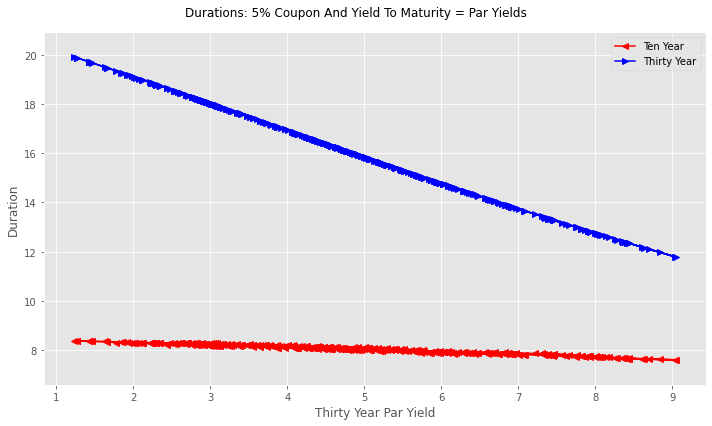

In [16]:
save_config={}
xaxis=par_yields_monthly['dgs30']
data=[par_yields_monthly['Duration Ten 5 Coupon'],par_yields_monthly['Duration Thirty 5 Coupon']]
try:
    title = os.path.splitext(save_config['file_name'])[0]
#'file_name key not found set a default title.
except:
    title = 'Durations: 5% Coupon And Yield To Maturity = Par Yields'

# Define the names for the data series that will appear in the plot's legend.
series = ['Ten Year', 'Thirty Year']

# Define the label for the y-axis.
ylabel = 'Duration'

# Define the label for the x-axis.
xlabel = 'Thirty Year Par Yield'

#'data' contains two series (ten and thirty durations).
x = len(data)

# Define markers for the plot.
markers = ['<','>']*round(x/2+x%2+0.001)

# Define the lower bound for the y-axis.
lower = min(np.nanmin(data[0]), np.nanmin(data[1])) -1

# Define the upper bound for the y-axis.
# considering NaN values (not a number) and adds a small buffer (0.5) for padding.
upper = max(np.nanmax(data[0]), np.nanmax(data[1])) + 1

# Define the y-axis limits (minimum and maximum values).
ylim = [lower, upper]

# Define the size of the plot (width, height) in inches.
size = (10, 6)
# Define colors as red and blue
colors=['r','b']
# This function generates and possibly saves a plot.
one_y_axis(xaxis, data, title, series, xlabel, ylabel, markers, size, ylim,
           save_config=save_config,colors=colors)

This graph demonstrates that fixing the coupon highlights the negative relation between duration and yield to maturity. For a thirty-year bond, the duration exhibits notable changes with varying yields to maturity: slightly less than 16 at 5%, slightly less than 17 at 4%, and slightly more than 14.75 at 6%. The differences are less pronounced for the ten-year bond, with the duration being slightly less than eight at 5%, slightly more at 4%, and slightly less again at 6%.

Understanding duration dynamics is crucial for investors. Because duration decreases as the yield to maturity increases, investors typically experience better outcomes than what is suggested by the duration calculation. Specifically, decreasing rates lead to higher gains, and increasing rates result in smaller losses. This advantageous phenomenon is known as convexity-the focus of the next chapter.


## <font color='green'>Application: Calculate Duration at Different Yields to Maturity

<div style="
    border-left: 12px solid green;
    line-height: 1.5;
    padding: 15px">
<br>

**Settlement date is December 31$^{st}$ 2025**

|Maturity|Coupon|Low Rate|Mid Rate|High Rate|
|-------|-------|---------|-----|-----|
|&nbsp;&nbsp;&nbsp;December 31$^{st}$ 2035|&nbsp;&nbsp;&nbsp;5.00|&emsp;4.0%|&emsp;5.0%|&emsp;6.0%|
|&nbsp;&nbsp;&nbsp;December 31$^{st}$ 2055|&nbsp;&nbsp;&nbsp;5.00|&emsp;4.0%|&emsp;5.0%|&emsp;6.0%|










 see [Chapter Seven Hints: Calculate Duration At Different Yields To Maturity](https://patrickjhess.github.io/Hints-Results/Chapter_Seven_Hints.html#chapter-seven-hints), and check the [expected results here](https://patrickjhess.github.io/Hints-Results/Chapter_Seven_Hints.html#chapter-seven-results).

</div>

## <span style="text-align: left; color:green; font-family: 'Franklin Gothic Medium', sans-serif; margin-top: 1.0em; margin-bottom: 0em; font-style: italic;">Chapter Exercise</span>
<span style="text-align: left; color:green; font-family: 'Franklin Gothic Medium', sans-serif; margin-top: 0; margin-bottom: 0.5em; font-style: italic;
"><big></big>
</span>


<div style="background-color:LightGray;
    border-left: 12px solid green;
    font-family: 'Garamond', serif;
    font-size: 17px;
    line-height: 1.5;
    padding: 15px">
<br>

**Settlement date is January 31$^{st}$ 2026**


Compare the acutal and duration forecasted rates of change in bond prices.


|Maturity|Coupon|Initial YTM|7% YTM|3% YTM|5.25% YTM|4.75% YTM|
|-------|-------|-----------|------------|--------|-----|----|
|&nbsp;&nbsp;&nbsp;December 31$^{st}$ 2035|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.0|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5%|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;7%|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3%|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.25%|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;4.75%|
|&nbsp;&nbsp;&nbsp;December 31$^{st}$ 2055|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.0|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5%|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;7%|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3%|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.25%|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;4.75%|


 see [Chapter Seven Hints: Compare the Actual and Duration Forecasted Rates of Change in Bond Prices](https://patrickjhess.github.io/Hints-Results/Chapter_Seven_Hints.html#chapter-seven-hints), and check the [expected results here](https://patrickjhess.github.io/Hints-Results/Chapter_Seven_Hints.html#chapter-seven-results).

</div>

## <font color='green'>Take a deeper dive with Gemini</font>


Some suggestions to get you started.

1.   **Should Property & Casualty and Life Insurance companies own bonds with different or similar durations?**

2.   **How does duration interact with reinvestment rate risk?**

3.  **Do companies use duration to hedge?**

4.  **What term structure risk does duration measure?**

[Here is the link where you can copy and paste the questions](https://gemini.google.com)